In [639]:
from datasets import load_dataset
import numpy as np
import os
from PIL import Image, ImageDraw

In [640]:
MODEL_NAME = "microsoft/conditional-detr-resnet-50"  # or "facebook/detr-resnet-50"

In [641]:
mcity_fe = load_dataset("dbogdollumich/mcity_fisheye", token=True)
print(mcity_fe["train"][0])

IMAGE_WIDTH = mcity_fe["train"][0]["image"].size[0]
IMAGE_HEIGHT = mcity_fe["train"][0]["image"].size[1]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x960 at 0x7F2DED029C00>, 'objects': {'bbox': [[310.0, 502.0, 34.0, 71.0], [290.0, 687.0, 17.0, 38.0], [479.0, 152.0, 53.0, 26.0], [843.0, 314.0, 67.0, 62.0], [948.0, 370.0, 36.0, 48.0], [1001.0, 399.0, 28.0, 40.0], [1039.0, 434.0, 12.0, 29.0], [810.0, 377.0, 98.0, 77.0], [1027.0, 465.0, 17.0, 30.0], [1068.0, 481.0, 11.0, 27.0], [1087.0, 498.0, 7.0, 15.0], [888.0, 286.0, 49.0, 48.0], [981.0, 343.0, 27.0, 44.0], [1024.0, 379.0, 20.0, 35.0], [206.0, 508.0, 11.0, 21.0], [191.0, 496.0, 13.0, 29.0], [1099.0, 499.0, 4.0, 14.0], [1050.0, 341.0, 10.0, 10.0]], 'categories': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 0, 4]}}


In [642]:
from transformers import AutoImageProcessor

# https://huggingface.co/docs/transformers/v4.44.2/en/model_doc/detr#transformers.DetrImageProcessor
image_processor = AutoImageProcessor.from_pretrained(
    MODEL_NAME,
    do_resize=True,
    size={"max_height": IMAGE_HEIGHT, "max_width": IMAGE_WIDTH},
    do_pad=True,
    pad_size={"height": IMAGE_HEIGHT, "width": IMAGE_WIDTH},
    do_convert_annotations=False,  # expects YOLO (center_x, center_y, width, height) between [0,1]
)

Check the [DETR](https://huggingface.co/docs/transformers/model_doc/detr) model page to find out how annotations need to be formatted and write converter with GitHub Copilot:
>{‘image_id’: int, ‘annotations’: List[Dict]} each Dict being a COCO object annotation



In [643]:
def coco_to_yolo(top_left_x, top_left_y, width, height, image_width, image_height):
    """
    Input: Bbox in absolute values, corner coordinates (COCO)
    Return: Bbox in relative values, center coordinates (YOLO)
    """
    center_x = (top_left_x + width / 2) / image_width
    center_y = (top_left_y + height / 2) / image_height
    width /= image_width
    height /= image_height

    return center_x, center_y, width, height


def yolo_to_coco(center_x, center_y, width, height, image_width, image_height):
    """
    Input: Bbox in relative values, center coordinates (YOLO)
    Return: Bbox in absolute values, corner coordinates (COCO)
    """
    width *= image_width
    height *= image_height
    top_left_x = center_x * image_width - width / 2
    top_left_y = center_y * image_height - height / 2

    return top_left_x, top_left_y, width, height


def convert_to_coco_format_w_yolo_bbox(
    image_id, annotations, image_width, image_height
):
    """
    Convert annotations to COCO format from the HuggingFace format
    https://huggingface.co/docs/datasets/v2.7.1/en/image_dataset

    HuggingFace DETR needs COCO format with normalized YOLO bboxes:
    https://huggingface.co/docs/transformers/v4.44.2/en/model_doc/detr#transformers.DetrImageProcessor
    """
    coco_annotations = []
    for bbox, category in zip(annotations["bbox"], annotations["categories"]):
        # Convert bbox to YOLO format
        top_left_x, top_left_y, width, height = bbox
        center_x, center_y, width, height = coco_to_yolo(
            top_left_x, top_left_y, width, height, image_width, image_height
        )

        coco_annotation = {
            "image_id": image_id,
            "bbox": [center_x, center_y, width, height],
            "category_id": category,
            "area": width
            * height
            * image_width
            * image_height,  # width * height in pixel values
            "iscrowd": 0,  # Assuming no crowd annotations
        }
        coco_annotations.append(coco_annotation)

    return {"image_id": image_id, "annotations": coco_annotations}

Visualize the data with the newly converted labels

['car', 'truck', 'bus', 'trailer', 'motorbike/cycler', 'pedestrian', 'van', 'pickup']


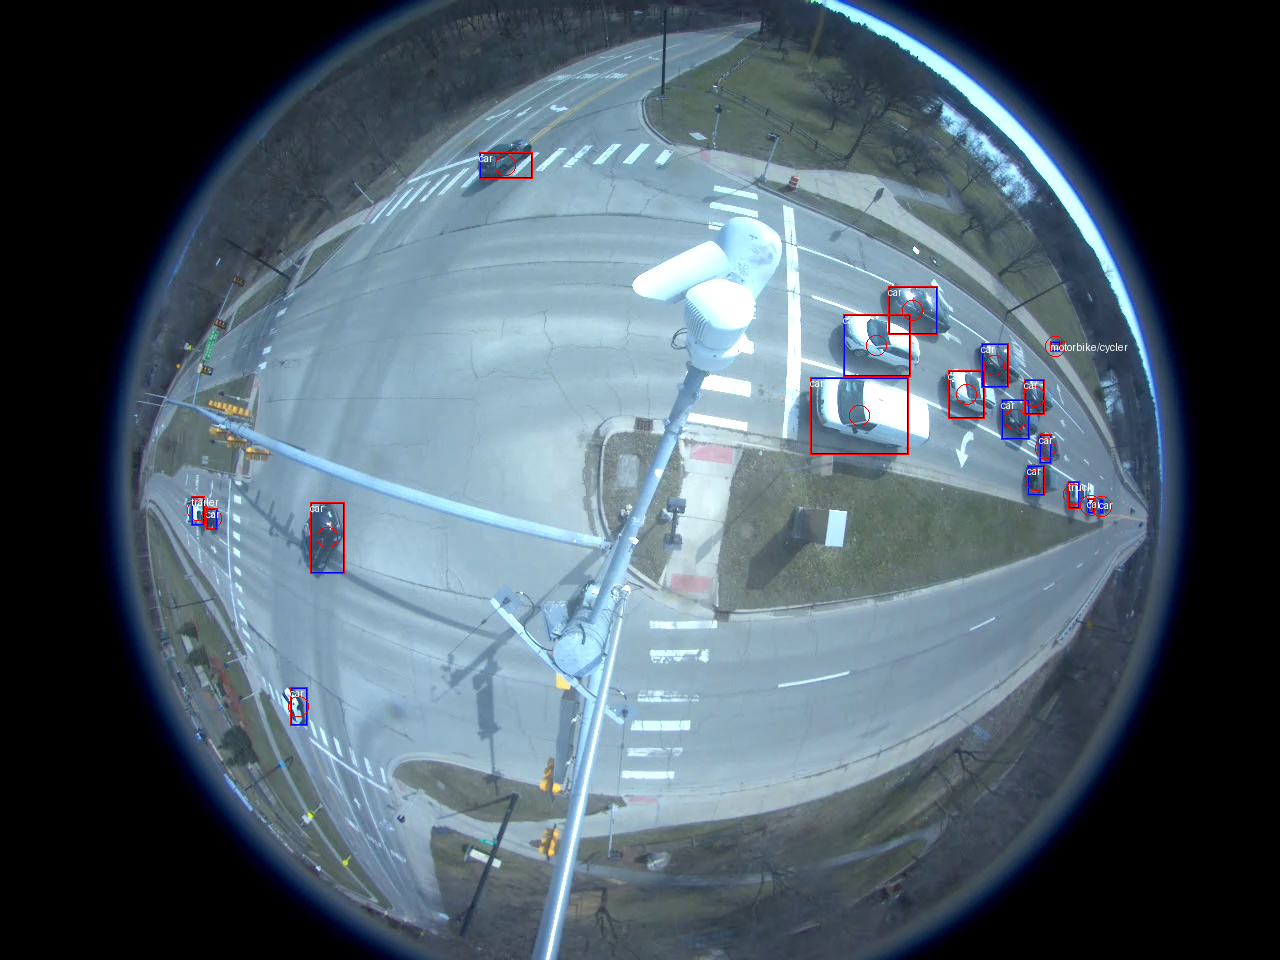

In [644]:
image = mcity_fe["train"][0]["image"]
image_width = image.size[0]
image_height = image.size[1]
annotations = mcity_fe["train"][0]["objects"]
draw = ImageDraw.Draw(image)

categories = mcity_fe["train"].features["objects"]["categories"].feature.names
print(categories)
id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(mcity_fe["train"][0]["objects"]["bbox"])):
    bbox = mcity_fe["train"][0]["objects"]["bbox"][i]
    top_left_x, top_left_y, width, height = bbox  # Dataset has labels in COCO format
    draw.rectangle(
        (top_left_x, top_left_y, top_left_x + width, top_left_y + height),
        outline="blue",
        width=2,
    )

    center_x, center_y, width, height = coco_to_yolo(
        top_left_x, top_left_y, width, height, image_width, image_height
    )  # Test converter
    draw.circle(
        (center_x * image_width, center_y * image_height),
        radius=10,
        outline="red",
        width=1,
    )

    top_left_x, top_left_y, width, height = yolo_to_coco(
        center_x, center_y, width, height, image_width, image_height
    )  # Test converter
    draw.rectangle(
        (top_left_x, top_left_y, top_left_x + width, top_left_y + height),
        outline="red",
        width=1,
    )

    class_id = mcity_fe["train"][0]["objects"]["categories"][i]
    draw.text((top_left_x, top_left_y), id2label[class_id], fill="white")

image  # Jupyter notebook trick to visualize inline

In [645]:
def transform_batch(examples, image_processor, return_pixel_mask=False):
    """Apply format annotations in COCO format for object detection task"""

    images = []
    annotations = []
    for id, (image, objects) in enumerate(zip(examples["image"], examples["objects"])):
        image_np = np.array(image)
        images.append(image_np)

        # format annotations in COCO format
        formatted_annotations = convert_to_coco_format_w_yolo_bbox(
            id, objects, image.size[0], image.size[1]
        )
        annotations.append(formatted_annotations)

    # Apply the image processor transformations: resizing, rescaling, normalization
    result = image_processor(
        images=images, annotations=annotations, return_tensors="pt"
    )

    if not return_pixel_mask:
        result.pop("pixel_mask", None)

    return result

In [646]:
from functools import partial

# Make transform functions for batch and apply for dataset splits
train_transform_batch = partial(transform_batch, image_processor=image_processor)
validation_transform_batch = partial(transform_batch, image_processor=image_processor)

mcity_fe["train"] = mcity_fe["train"].with_transform(train_transform_batch)
mcity_fe["validation"] = mcity_fe["validation"].with_transform(
    validation_transform_batch
)

Generate batches and support for differently sized images: Pad images (which are now pixel_values) to the largest image in a batch, and create a corresponding pixel_mask to indicate which pixels are real (1) and which are padding (0)

In [647]:
import torch


def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    if "pixel_mask" in batch[0]:
        data["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])
    return data

Compute metrics

In [648]:
import numpy as np
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch import nn


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


def post_process_object_detection(outputs, threshold: float = 0.5):
    """
    Converts the raw output of [`DetrForObjectDetection`] into dictionary. Removed bbox conversion from original version https://github.com/huggingface/transformers/blob/v4.44.2/src/transformers/models/detr/image_processing_detr.py#L1773

    Args:
        outputs ([`DetrObjectDetectionOutput`]):
            Raw outputs of the model.
        threshold (`float`, *optional*):
            Score threshold to keep object detection predictions.
    Returns:
        `List[Dict]`: A list of dictionaries, each dictionary containing the scores, labels and boxes for an image
        in the batch as predicted by the model.
    """
    out_logits, out_bbox = outputs.logits, outputs.pred_boxes

    prob = nn.functional.softmax(out_logits, -1)
    scores, labels = prob[..., :-1].max(-1)

    results = []
    for s, l, b in zip(scores, labels, out_bbox):
        score = s[s > threshold]
        label = l[s > threshold]
        box = b[s > threshold]
        results.append({"scores": score, "labels": label, "boxes": box})

    return results


@torch.no_grad()
def compute_metrics(evaluation_results, image_processor, threshold=0.0, id2label=None):
    """
    Compute mean average mAP, mAR and their variants for the object detection task.

    Args:
        evaluation_results (EvalPrediction): Predictions and targets from evaluation.
        threshold (float, optional): Threshold to filter predicted boxes by confidence. Defaults to 0.0.
        id2label (Optional[dict], optional): Mapping from class id to class name. Defaults to None.

    Returns:
        Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
    """

    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation we need to provide:
    #  - targets in a form of list of dictionaries with keys "boxes", "labels"
    #  - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    post_processed_targets = []
    post_processed_predictions = []

    # Collect targets in the required format for metric computation
    for batch in targets:
        for image_target in batch:
            img_height, img_width = image_target["orig_size"]
            boxes = image_target["boxes"]  # list
            coco_boxes = [
                yolo_to_coco(box[0], box[1], box[2], box[3], img_width, img_height)
                for box in boxes
            ]
            boxes = torch.tensor(coco_boxes)
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format for metric computation
    for batch in predictions:
        batch_logits, batch_boxes = batch[1], batch[2]

        # Initialize an empty list to store the converted boxes
        coco_boxes = []

        # Iterate over the batch dimension
        for batch in batch_boxes:
            # Initialize an empty list to store the converted boxes for the current batch
            batch_converted_boxes = []

            # Iterate over the boxes within the current batch
            for box in batch:
                # Convert the box using yolo_to_coco
                converted_box = yolo_to_coco(
                    box[0], box[1], box[2], box[3], img_width, img_height
                )
                # Append the converted box to the list for the current batch
                batch_converted_boxes.append(converted_box)

            # Append the converted boxes for the current batch to the main list
            coco_boxes.append(batch_converted_boxes)

        output = ModelOutput(
            logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(coco_boxes)
        )
        post_processed_output = post_process_object_detection(
            output, threshold=threshold
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics

    metric = MeanAveragePrecision(box_format="xywh", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")
    for class_id, class_map, class_mar in zip(
        classes, map_per_class, mar_100_per_class
    ):
        class_name = (
            id2label[class_id.item()] if id2label is not None else class_id.item()
        )
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar

    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics


eval_compute_metrics_fn = partial(
    compute_metrics, image_processor=image_processor, id2label=id2label, threshold=0.0
)

In [649]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    MODEL_NAME,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([8]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([8, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [650]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./model",
    num_train_epochs=50,
    fp16=False,
    per_device_train_batch_size=8,
    dataloader_num_workers=4,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    weight_decay=1e-4,
    max_grad_norm=0.01,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
    push_to_hub=False,
)

In [651]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=mcity_fe["train"],
    eval_dataset=mcity_fe["validation"],
    tokenizer=image_processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
  2%|▏         | 250/12500 [01:21<1:09:02,  2.96it/s]



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                      

                                         
                                          

{'eval_loss': 1.4548745155334473, 'eval_map': 0.0575, 'eval_map_50': 0.0825, 'eval_map_75': 0.0669, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.0575, 'eval_mar_1': 0.0059, 'eval_mar_10': 0.036, 'eval_mar_100': 0.101, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.101, 'eval_map_car': 0.46, 'eval_mar_100_car': 0.8078, 'eval_map_truck': 0.0, 'eval_mar_100_truck': 0.0, 'eval_map_bus': 0.0, 'eval_mar_100_bus': 0.0, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.0, 'eval_mar_100_pedestrian': 0.0, 'eval_map_van': 0.0, 'eval_mar_100_van': 0.0, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.0666, 'eval_samples_per_second': 26.508, 'eval_steps_per_second': 3.314, 'epoch': 1.0}


  4%|▍         | 500/12500 [03:11<1:08:18,  2.93it/s] 


                                      
                                                     

  4%|▍         | 500/12500 [03:11<1:08:18,  2.93it/s]

{'loss': 2.4308, 'grad_norm': 9.325479507446289, 'learning_rate': 4.980286753286195e-05, 'epoch': 2.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                      

                                         
                                                     


  4%|▍         | 500/12500 [03:39<1:08:18,  2.93it/s]


{'eval_loss': 1.0446057319641113, 'eval_map': 0.0863, 'eval_map_50': 0.1085, 'eval_map_75': 0.0991, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.0863, 'eval_mar_1': 0.009, 'eval_mar_10': 0.0569, 'eval_mar_100': 0.1165, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.1165, 'eval_map_car': 0.689, 'eval_mar_100_car': 0.8691, 'eval_map_truck': 0.0, 'eval_mar_100_truck': 0.0, 'eval_map_bus': 0.0, 'eval_mar_100_bus': 0.0, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.0015, 'eval_mar_100_pedestrian': 0.0628, 'eval_map_van': 0.0, 'eval_mar_100_van': 0.0, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.3679, 'eval_samples_per_second': 26.227, 'eval_steps_per_second': 3.278, 'epoch': 2.0}


  6%|▌         | 750/12500 [05:00<1:07:17,  2.91it/s] 



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                      

                                         
                                                     


  6%|▌         | 750/12500 [05:29<1:07:17,  2.91it/s]


{'eval_loss': 0.9375829100608826, 'eval_map': 0.0962, 'eval_map_50': 0.1238, 'eval_map_75': 0.1072, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.0962, 'eval_mar_1': 0.0188, 'eval_mar_10': 0.0846, 'eval_mar_100': 0.1558, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.1558, 'eval_map_car': 0.7321, 'eval_mar_100_car': 0.8918, 'eval_map_truck': 0.0, 'eval_mar_100_truck': 0.0, 'eval_map_bus': 0.0, 'eval_mar_100_bus': 0.0, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.0376, 'eval_mar_100_pedestrian': 0.3546, 'eval_map_van': 0.0, 'eval_mar_100_van': 0.0, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.5635, 'eval_samples_per_second': 26.047, 'eval_steps_per_second': 3.256, 'epoch': 3.0}


  8%|▊         | 1000/12500 [06:47<1:02:11,  3.08it/s]


                                      
                                                      

  8%|▊         | 1000/12500 [06:47<1:02:11,  3.08it/s]

{'loss': 0.7434, 'grad_norm': 11.869744300842285, 'learning_rate': 4.9214579028215776e-05, 'epoch': 4.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                      

                                         
                                                      


  8%|▊         | 1000/12500 [07:14<1:02:11,  3.08it/s]


{'eval_loss': 0.8574802875518799, 'eval_map': 0.101, 'eval_map_50': 0.124, 'eval_map_75': 0.1108, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.101, 'eval_mar_1': 0.0152, 'eval_mar_10': 0.088, 'eval_mar_100': 0.1799, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.1799, 'eval_map_car': 0.7746, 'eval_mar_100_car': 0.9101, 'eval_map_truck': 0.0, 'eval_mar_100_truck': 0.0, 'eval_map_bus': 0.0, 'eval_mar_100_bus': 0.0, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.0338, 'eval_mar_100_pedestrian': 0.5294, 'eval_map_van': 0.0, 'eval_mar_100_van': 0.0, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 27.6346, 'eval_samples_per_second': 26.923, 'eval_steps_per_second': 3.365, 'epoch': 4.0}


 10%|█         | 1250/12500 [08:32<1:03:22,  2.96it/s] 



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                      

                                         
                                                      


 10%|█         | 1250/12500 [09:00<1:03:22,  2.96it/s]


{'eval_loss': 0.8223092555999756, 'eval_map': 0.1055, 'eval_map_50': 0.1284, 'eval_map_75': 0.1156, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1055, 'eval_mar_1': 0.022, 'eval_mar_10': 0.0959, 'eval_mar_100': 0.1894, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.1894, 'eval_map_car': 0.7844, 'eval_mar_100_car': 0.9127, 'eval_map_truck': 0.0, 'eval_mar_100_truck': 0.0, 'eval_map_bus': 0.0, 'eval_mar_100_bus': 0.0, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.0597, 'eval_mar_100_pedestrian': 0.6028, 'eval_map_van': 0.0, 'eval_mar_100_van': 0.0, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 27.9268, 'eval_samples_per_second': 26.641, 'eval_steps_per_second': 3.33, 'epoch': 5.0}


 12%|█▏        | 1500/12500 [10:18<1:01:47,  2.97it/s] 


                                      
                                                      

 12%|█▏        | 1500/12500 [10:18<1:01:47,  2.97it/s]

{'loss': 0.6356, 'grad_norm': 15.417402267456055, 'learning_rate': 4.8244412147206284e-05, 'epoch': 6.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                      

                                         
                                                      


 12%|█▏        | 1500/12500 [10:46<1:01:47,  2.97it/s]


{'eval_loss': 0.7462939023971558, 'eval_map': 0.1195, 'eval_map_50': 0.1414, 'eval_map_75': 0.1328, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1195, 'eval_mar_1': 0.0406, 'eval_mar_10': 0.1214, 'eval_mar_100': 0.2034, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.2034, 'eval_map_car': 0.793, 'eval_mar_100_car': 0.9154, 'eval_map_truck': 0.0, 'eval_mar_100_truck': 0.0, 'eval_map_bus': 0.0074, 'eval_mar_100_bus': 0.0221, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.1552, 'eval_mar_100_pedestrian': 0.6838, 'eval_map_van': 0.0006, 'eval_mar_100_van': 0.0062, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.0703, 'eval_samples_per_second': 26.505, 'eval_steps_per_second': 3.313, 'epoch': 6.0}


 14%|█▍        | 1750/12500 [12:03<58:34,  3.06it/s]   



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                      

                                         
                                                    


 14%|█▍        | 1750/12500 [12:31<58:34,  3.06it/s]


{'eval_loss': 0.6970953345298767, 'eval_map': 0.1318, 'eval_map_50': 0.1525, 'eval_map_75': 0.1448, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1318, 'eval_mar_1': 0.0529, 'eval_mar_10': 0.1415, 'eval_mar_100': 0.2089, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.2089, 'eval_map_car': 0.805, 'eval_mar_100_car': 0.9147, 'eval_map_truck': 0.0, 'eval_mar_100_truck': 0.0, 'eval_map_bus': 0.0103, 'eval_mar_100_bus': 0.0231, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.2365, 'eval_mar_100_pedestrian': 0.7145, 'eval_map_van': 0.0025, 'eval_mar_100_van': 0.0187, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 27.9293, 'eval_samples_per_second': 26.639, 'eval_steps_per_second': 3.33, 'epoch': 7.0}


 16%|█▌        | 2000/12500 [13:54<1:33:58,  1.86it/s] 


                                      
                                                      

 16%|█▌        | 2000/12500 [13:54<1:33:58,  1.86it/s]

{'loss': 0.5794, 'grad_norm': 13.130463600158691, 'learning_rate': 4.690766700109659e-05, 'epoch': 8.0}































































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                      

                                         
                                                      


 16%|█▌        | 2000/12500 [14:35<1:33:58,  1.86it/s]


{'eval_loss': 0.6758735179901123, 'eval_map': 0.1419, 'eval_map_50': 0.1636, 'eval_map_75': 0.1555, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1419, 'eval_mar_1': 0.0591, 'eval_mar_10': 0.1463, 'eval_mar_100': 0.2113, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.2113, 'eval_map_car': 0.7927, 'eval_mar_100_car': 0.905, 'eval_map_truck': 0.0, 'eval_mar_100_truck': 0.0, 'eval_map_bus': 0.0065, 'eval_mar_100_bus': 0.0269, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.3341, 'eval_mar_100_pedestrian': 0.7272, 'eval_map_van': 0.0022, 'eval_mar_100_van': 0.0316, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 41.4607, 'eval_samples_per_second': 17.945, 'eval_steps_per_second': 2.243, 'epoch': 8.0}


 18%|█▊        | 2250/12500 [16:11<56:07,  3.04it/s]   



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                      

                                         
                                                    


 18%|█▊        | 2250/12500 [16:40<56:07,  3.04it/s]


{'eval_loss': 0.6807722449302673, 'eval_map': 0.1467, 'eval_map_50': 0.1692, 'eval_map_75': 0.1587, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1467, 'eval_mar_1': 0.0641, 'eval_mar_10': 0.156, 'eval_mar_100': 0.2183, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.2183, 'eval_map_car': 0.78, 'eval_mar_100_car': 0.8923, 'eval_map_truck': 0.0, 'eval_mar_100_truck': 0.0, 'eval_map_bus': 0.0121, 'eval_mar_100_bus': 0.0413, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.3765, 'eval_mar_100_pedestrian': 0.7515, 'eval_map_van': 0.0053, 'eval_mar_100_van': 0.0612, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.3599, 'eval_samples_per_second': 26.234, 'eval_steps_per_second': 3.279, 'epoch': 9.0}


 20%|██        | 2500/12500 [18:00<58:26,  2.85it/s]   


                                      
                                                    

 20%|██        | 2500/12500 [18:00<58:26,  2.85it/s]

{'loss': 0.5426, 'grad_norm': 23.52615737915039, 'learning_rate': 4.522542485937369e-05, 'epoch': 10.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                      

                                         
                                                    


 20%|██        | 2500/12500 [18:29<58:26,  2.85it/s]


{'eval_loss': 0.6539725065231323, 'eval_map': 0.1575, 'eval_map_50': 0.1809, 'eval_map_75': 0.1702, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1575, 'eval_mar_1': 0.0653, 'eval_mar_10': 0.1576, 'eval_mar_100': 0.2247, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.2247, 'eval_map_car': 0.8006, 'eval_mar_100_car': 0.914, 'eval_map_truck': 0.0, 'eval_mar_100_truck': 0.0, 'eval_map_bus': 0.0122, 'eval_mar_100_bus': 0.0442, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.4375, 'eval_mar_100_pedestrian': 0.7413, 'eval_map_van': 0.0094, 'eval_mar_100_van': 0.0981, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.4005, 'eval_samples_per_second': 26.197, 'eval_steps_per_second': 3.275, 'epoch': 10.0}


 22%|██▏       | 2750/12500 [19:46<55:22,  2.93it/s]   



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                      

                                         
                                                    


 22%|██▏       | 2750/12500 [20:14<55:22,  2.93it/s]


{'eval_loss': 0.6221262812614441, 'eval_map': 0.1559, 'eval_map_50': 0.1796, 'eval_map_75': 0.1673, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1559, 'eval_mar_1': 0.0683, 'eval_mar_10': 0.1752, 'eval_mar_100': 0.2438, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.2438, 'eval_map_car': 0.78, 'eval_mar_100_car': 0.9007, 'eval_map_truck': 0.0057, 'eval_mar_100_truck': 0.0521, 'eval_map_bus': 0.0095, 'eval_mar_100_bus': 0.0346, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.4384, 'eval_mar_100_pedestrian': 0.7592, 'eval_map_van': 0.0139, 'eval_mar_100_van': 0.2038, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.5483, 'eval_samples_per_second': 26.061, 'eval_steps_per_second': 3.258, 'epoch': 11.0}


 24%|██▍       | 3000/12500 [21:34<54:09,  2.92it/s]   


                                        
                                                    

 24%|██▍       | 3000/12500 [21:34<54:09,  2.92it/s]

{'loss': 0.5076, 'grad_norm': 12.072442054748535, 'learning_rate': 4.3224215685535294e-05, 'epoch': 12.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 24%|██▍       | 3000/12500 [22:01<54:09,  2.92it/s]


{'eval_loss': 0.607509970664978, 'eval_map': 0.1653, 'eval_map_50': 0.1897, 'eval_map_75': 0.1781, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1653, 'eval_mar_1': 0.0819, 'eval_mar_10': 0.1894, 'eval_mar_100': 0.2603, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.2603, 'eval_map_car': 0.7913, 'eval_mar_100_car': 0.9103, 'eval_map_truck': 0.0124, 'eval_mar_100_truck': 0.0865, 'eval_map_bus': 0.0077, 'eval_mar_100_bus': 0.0298, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.4925, 'eval_mar_100_pedestrian': 0.7768, 'eval_map_van': 0.0187, 'eval_mar_100_van': 0.2789, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 27.5574, 'eval_samples_per_second': 26.998, 'eval_steps_per_second': 3.375, 'epoch': 12.0}


 26%|██▌       | 3250/12500 [23:19<48:54,  3.15it/s]   



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 26%|██▌       | 3250/12500 [23:47<48:54,  3.15it/s]


{'eval_loss': 0.6078945398330688, 'eval_map': 0.1718, 'eval_map_50': 0.198, 'eval_map_75': 0.1847, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1718, 'eval_mar_1': 0.0859, 'eval_mar_10': 0.193, 'eval_mar_100': 0.2582, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.2582, 'eval_map_car': 0.7806, 'eval_mar_100_car': 0.8966, 'eval_map_truck': 0.0422, 'eval_mar_100_truck': 0.1104, 'eval_map_bus': 0.012, 'eval_mar_100_bus': 0.0413, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.518, 'eval_mar_100_pedestrian': 0.7768, 'eval_map_van': 0.0214, 'eval_mar_100_van': 0.2402, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 27.9917, 'eval_samples_per_second': 26.579, 'eval_steps_per_second': 3.322, 'epoch': 13.0}


 28%|██▊       | 3500/12500 [25:06<48:36,  3.09it/s]   


                                        
                                                    

 28%|██▊       | 3500/12500 [25:06<48:36,  3.09it/s]

{'loss': 0.479, 'grad_norm': 10.219185829162598, 'learning_rate': 4.093559974371725e-05, 'epoch': 14.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 28%|██▊       | 3500/12500 [25:35<48:36,  3.09it/s]


{'eval_loss': 0.5902695059776306, 'eval_map': 0.1786, 'eval_map_50': 0.2034, 'eval_map_75': 0.1912, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1786, 'eval_mar_1': 0.0881, 'eval_mar_10': 0.1913, 'eval_mar_100': 0.2597, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.2597, 'eval_map_car': 0.8077, 'eval_mar_100_car': 0.9134, 'eval_map_truck': 0.0515, 'eval_mar_100_truck': 0.1115, 'eval_map_bus': 0.0046, 'eval_mar_100_bus': 0.0202, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.5455, 'eval_mar_100_pedestrian': 0.8127, 'eval_map_van': 0.0194, 'eval_mar_100_van': 0.2201, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.9029, 'eval_samples_per_second': 25.741, 'eval_steps_per_second': 3.218, 'epoch': 14.0}


 30%|███       | 3750/12500 [26:53<51:34,  2.83it/s]   



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 30%|███       | 3750/12500 [27:23<51:34,  2.83it/s]


{'eval_loss': 0.5986272096633911, 'eval_map': 0.1752, 'eval_map_50': 0.2027, 'eval_map_75': 0.1878, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1752, 'eval_mar_1': 0.1124, 'eval_mar_10': 0.2342, 'eval_mar_100': 0.3052, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3052, 'eval_map_car': 0.8078, 'eval_mar_100_car': 0.9105, 'eval_map_truck': 0.0456, 'eval_mar_100_truck': 0.2969, 'eval_map_bus': 0.001, 'eval_mar_100_bus': 0.0337, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.5194, 'eval_mar_100_pedestrian': 0.8157, 'eval_map_van': 0.0279, 'eval_mar_100_van': 0.3852, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 30.2151, 'eval_samples_per_second': 24.623, 'eval_steps_per_second': 3.078, 'epoch': 15.0}


 32%|███▏      | 4000/12500 [28:41<46:06,  3.07it/s]   


                                        
                                                    

 32%|███▏      | 4000/12500 [28:41<46:06,  3.07it/s]

{'loss': 0.4507, 'grad_norm': 8.896895408630371, 'learning_rate': 3.8395669874474915e-05, 'epoch': 16.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 32%|███▏      | 4000/12500 [29:10<46:06,  3.07it/s]


{'eval_loss': 0.5838902592658997, 'eval_map': 0.1827, 'eval_map_50': 0.2095, 'eval_map_75': 0.1955, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1827, 'eval_mar_1': 0.1054, 'eval_mar_10': 0.2189, 'eval_mar_100': 0.3047, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3047, 'eval_map_car': 0.8156, 'eval_mar_100_car': 0.9159, 'eval_map_truck': 0.0788, 'eval_mar_100_truck': 0.2469, 'eval_map_bus': 0.0021, 'eval_mar_100_bus': 0.1327, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.5424, 'eval_mar_100_pedestrian': 0.7925, 'eval_map_van': 0.0223, 'eval_mar_100_van': 0.3493, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.3608, 'eval_samples_per_second': 26.233, 'eval_steps_per_second': 3.279, 'epoch': 16.0}


 34%|███▍      | 4250/12500 [30:28<43:53,  3.13it/s]   



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 34%|███▍      | 4250/12500 [30:56<43:53,  3.13it/s]


{'eval_loss': 0.5822376012802124, 'eval_map': 0.1791, 'eval_map_50': 0.2042, 'eval_map_75': 0.1912, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1791, 'eval_mar_1': 0.0982, 'eval_mar_10': 0.2172, 'eval_mar_100': 0.2957, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.2957, 'eval_map_car': 0.8076, 'eval_mar_100_car': 0.9073, 'eval_map_truck': 0.0548, 'eval_mar_100_truck': 0.226, 'eval_map_bus': 0.0001, 'eval_mar_100_bus': 0.0596, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.5455, 'eval_mar_100_pedestrian': 0.795, 'eval_map_van': 0.0251, 'eval_mar_100_van': 0.378, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.4281, 'eval_samples_per_second': 26.171, 'eval_steps_per_second': 3.271, 'epoch': 17.0}


 36%|███▌      | 4500/12500 [32:18<46:35,  2.86it/s]   


                                        
                                                    

 36%|███▌      | 4500/12500 [32:18<46:35,  2.86it/s]

{'loss': 0.43, 'grad_norm': 13.340495109558105, 'learning_rate': 3.564448228912682e-05, 'epoch': 18.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 36%|███▌      | 4500/12500 [32:47<46:35,  2.86it/s]


{'eval_loss': 0.5870776772499084, 'eval_map': 0.1746, 'eval_map_50': 0.2003, 'eval_map_75': 0.1858, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1746, 'eval_mar_1': 0.0955, 'eval_mar_10': 0.2124, 'eval_mar_100': 0.2829, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.2829, 'eval_map_car': 0.8078, 'eval_mar_100_car': 0.9148, 'eval_map_truck': 0.0507, 'eval_mar_100_truck': 0.2521, 'eval_map_bus': 0.0, 'eval_mar_100_bus': 0.0192, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.5192, 'eval_mar_100_pedestrian': 0.8015, 'eval_map_van': 0.0194, 'eval_mar_100_van': 0.2751, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 29.2101, 'eval_samples_per_second': 25.471, 'eval_steps_per_second': 3.184, 'epoch': 18.0}


 38%|███▊      | 4750/12500 [34:12<41:00,  3.15it/s]   



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 38%|███▊      | 4750/12500 [34:40<41:00,  3.15it/s]


{'eval_loss': 0.5998473763465881, 'eval_map': 0.1835, 'eval_map_50': 0.2088, 'eval_map_75': 0.196, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1835, 'eval_mar_1': 0.1148, 'eval_mar_10': 0.2383, 'eval_mar_100': 0.3288, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3288, 'eval_map_car': 0.8142, 'eval_mar_100_car': 0.9158, 'eval_map_truck': 0.072, 'eval_mar_100_truck': 0.3313, 'eval_map_bus': 0.001, 'eval_mar_100_bus': 0.1644, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.5556, 'eval_mar_100_pedestrian': 0.7976, 'eval_map_van': 0.0248, 'eval_mar_100_van': 0.4211, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.845, 'eval_samples_per_second': 25.793, 'eval_steps_per_second': 3.224, 'epoch': 19.0}


 40%|████      | 5000/12500 [35:59<42:33,  2.94it/s]   


                                        
                                                    

 40%|████      | 5000/12500 [35:59<42:33,  2.94it/s]

{'loss': 0.415, 'grad_norm': 34.179256439208984, 'learning_rate': 3.272542485937369e-05, 'epoch': 20.0}































































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 40%|████      | 5000/12500 [36:42<42:33,  2.94it/s]


{'eval_loss': 0.6045299768447876, 'eval_map': 0.1757, 'eval_map_50': 0.2018, 'eval_map_75': 0.1869, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1757, 'eval_mar_1': 0.1063, 'eval_mar_10': 0.228, 'eval_mar_100': 0.3015, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3015, 'eval_map_car': 0.7667, 'eval_mar_100_car': 0.8815, 'eval_map_truck': 0.0484, 'eval_mar_100_truck': 0.2052, 'eval_map_bus': 0.0009, 'eval_mar_100_bus': 0.0644, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.559, 'eval_mar_100_pedestrian': 0.8255, 'eval_map_van': 0.0304, 'eval_mar_100_van': 0.4354, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 43.3423, 'eval_samples_per_second': 17.166, 'eval_steps_per_second': 2.146, 'epoch': 20.0}


 42%|████▏     | 5250/12500 [38:17<41:50,  2.89it/s]   



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 42%|████▏     | 5250/12500 [38:46<41:50,  2.89it/s]


{'eval_loss': 0.5914019346237183, 'eval_map': 0.1857, 'eval_map_50': 0.2112, 'eval_map_75': 0.1973, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1857, 'eval_mar_1': 0.1109, 'eval_mar_10': 0.2465, 'eval_mar_100': 0.327, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.327, 'eval_map_car': 0.7897, 'eval_mar_100_car': 0.8993, 'eval_map_truck': 0.0551, 'eval_mar_100_truck': 0.2458, 'eval_map_bus': 0.0036, 'eval_mar_100_bus': 0.1644, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.5986, 'eval_mar_100_pedestrian': 0.8052, 'eval_map_van': 0.0389, 'eval_mar_100_van': 0.501, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 29.1832, 'eval_samples_per_second': 25.494, 'eval_steps_per_second': 3.187, 'epoch': 21.0}


 44%|████▍     | 5500/12500 [40:04<37:47,  3.09it/s]   


                                        
                                                    

 44%|████▍     | 5500/12500 [40:04<37:47,  3.09it/s]

{'loss': 0.4022, 'grad_norm': 10.202298164367676, 'learning_rate': 2.9684532864643122e-05, 'epoch': 22.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 44%|████▍     | 5500/12500 [40:32<37:47,  3.09it/s]


{'eval_loss': 0.6028074622154236, 'eval_map': 0.1845, 'eval_map_50': 0.2094, 'eval_map_75': 0.1965, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1845, 'eval_mar_1': 0.0968, 'eval_mar_10': 0.2378, 'eval_mar_100': 0.3389, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3389, 'eval_map_car': 0.8235, 'eval_mar_100_car': 0.9173, 'eval_map_truck': 0.0374, 'eval_mar_100_truck': 0.1771, 'eval_map_bus': 0.0007, 'eval_mar_100_bus': 0.2356, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.5758, 'eval_mar_100_pedestrian': 0.8191, 'eval_map_van': 0.0382, 'eval_mar_100_van': 0.5622, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.1818, 'eval_samples_per_second': 26.4, 'eval_steps_per_second': 3.3, 'epoch': 22.0}


 46%|████▌     | 5750/12500 [41:50<37:16,  3.02it/s]   



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 46%|████▌     | 5750/12500 [42:19<37:16,  3.02it/s]


{'eval_loss': 0.579572319984436, 'eval_map': 0.1863, 'eval_map_50': 0.2123, 'eval_map_75': 0.1984, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1863, 'eval_mar_1': 0.1085, 'eval_mar_10': 0.2383, 'eval_mar_100': 0.3279, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3279, 'eval_map_car': 0.8083, 'eval_mar_100_car': 0.9081, 'eval_map_truck': 0.0408, 'eval_mar_100_truck': 0.2083, 'eval_map_bus': 0.0008, 'eval_mar_100_bus': 0.2048, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.5973, 'eval_mar_100_pedestrian': 0.8012, 'eval_map_van': 0.0435, 'eval_mar_100_van': 0.5005, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 29.0557, 'eval_samples_per_second': 25.606, 'eval_steps_per_second': 3.201, 'epoch': 23.0}


 48%|████▊     | 6000/12500 [43:37<35:43,  3.03it/s]   


                                        
                                                    

 48%|████▊     | 6000/12500 [43:37<35:43,  3.03it/s]

{'loss': 0.3764, 'grad_norm': 89.92195129394531, 'learning_rate': 2.656976298823284e-05, 'epoch': 24.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 48%|████▊     | 6000/12500 [44:05<35:43,  3.03it/s]


{'eval_loss': 0.5851684212684631, 'eval_map': 0.1869, 'eval_map_50': 0.2132, 'eval_map_75': 0.1988, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1869, 'eval_mar_1': 0.105, 'eval_mar_10': 0.2305, 'eval_mar_100': 0.3056, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3056, 'eval_map_car': 0.8053, 'eval_mar_100_car': 0.9027, 'eval_map_truck': 0.0264, 'eval_mar_100_truck': 0.1281, 'eval_map_bus': 0.0006, 'eval_mar_100_bus': 0.1404, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.6092, 'eval_mar_100_pedestrian': 0.7971, 'eval_map_van': 0.0541, 'eval_mar_100_van': 0.4761, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.2533, 'eval_samples_per_second': 26.333, 'eval_steps_per_second': 3.292, 'epoch': 24.0}


 50%|█████     | 6250/12500 [45:22<34:20,  3.03it/s]   



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 50%|█████     | 6250/12500 [45:50<34:20,  3.03it/s]


{'eval_loss': 0.5842112302780151, 'eval_map': 0.1918, 'eval_map_50': 0.2167, 'eval_map_75': 0.2037, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1918, 'eval_mar_1': 0.1119, 'eval_mar_10': 0.2541, 'eval_mar_100': 0.3511, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3511, 'eval_map_car': 0.8161, 'eval_mar_100_car': 0.9135, 'eval_map_truck': 0.0553, 'eval_mar_100_truck': 0.2583, 'eval_map_bus': 0.0005, 'eval_mar_100_bus': 0.251, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.6085, 'eval_mar_100_pedestrian': 0.8119, 'eval_map_van': 0.0543, 'eval_mar_100_van': 0.5737, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.0261, 'eval_samples_per_second': 26.547, 'eval_steps_per_second': 3.318, 'epoch': 25.0}


 52%|█████▏    | 6500/12500 [47:11<33:23,  3.00it/s]   


                                        
                                                    

 52%|█████▏    | 6500/12500 [47:11<33:23,  3.00it/s]

{'loss': 0.3581, 'grad_norm': 22.449811935424805, 'learning_rate': 2.3430237011767167e-05, 'epoch': 26.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 52%|█████▏    | 6500/12500 [47:39<33:23,  3.00it/s]


{'eval_loss': 0.5978196859359741, 'eval_map': 0.1939, 'eval_map_50': 0.22, 'eval_map_75': 0.2056, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1939, 'eval_mar_1': 0.113, 'eval_mar_10': 0.2513, 'eval_mar_100': 0.3546, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3546, 'eval_map_car': 0.8282, 'eval_mar_100_car': 0.9186, 'eval_map_truck': 0.0676, 'eval_mar_100_truck': 0.2479, 'eval_map_bus': 0.0009, 'eval_mar_100_bus': 0.2952, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.6033, 'eval_mar_100_pedestrian': 0.8112, 'eval_map_van': 0.0509, 'eval_mar_100_van': 0.5641, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.3744, 'eval_samples_per_second': 26.221, 'eval_steps_per_second': 3.278, 'epoch': 26.0}


 54%|█████▍    | 6750/12500 [49:01<33:10,  2.89it/s]   



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 54%|█████▍    | 6750/12500 [49:29<33:10,  2.89it/s]


{'eval_loss': 0.5882831811904907, 'eval_map': 0.1959, 'eval_map_50': 0.2243, 'eval_map_75': 0.2085, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1959, 'eval_mar_1': 0.1162, 'eval_mar_10': 0.2509, 'eval_mar_100': 0.3338, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3338, 'eval_map_car': 0.8276, 'eval_mar_100_car': 0.9203, 'eval_map_truck': 0.0832, 'eval_mar_100_truck': 0.3417, 'eval_map_bus': 0.0033, 'eval_mar_100_bus': 0.1808, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.6038, 'eval_mar_100_pedestrian': 0.8002, 'eval_map_van': 0.0493, 'eval_mar_100_van': 0.4278, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.5785, 'eval_samples_per_second': 26.034, 'eval_steps_per_second': 3.254, 'epoch': 27.0}


 56%|█████▌    | 7000/12500 [50:48<30:02,  3.05it/s]   


                                        
                                                    

 56%|█████▌    | 7000/12500 [50:48<30:02,  3.05it/s]

{'loss': 0.3424, 'grad_norm': 18.652603149414062, 'learning_rate': 2.031546713535688e-05, 'epoch': 28.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 56%|█████▌    | 7000/12500 [51:16<30:02,  3.05it/s]


{'eval_loss': 0.6092395186424255, 'eval_map': 0.1919, 'eval_map_50': 0.2203, 'eval_map_75': 0.204, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1919, 'eval_mar_1': 0.1192, 'eval_mar_10': 0.2609, 'eval_mar_100': 0.3522, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3522, 'eval_map_car': 0.8169, 'eval_mar_100_car': 0.9162, 'eval_map_truck': 0.0899, 'eval_mar_100_truck': 0.375, 'eval_map_bus': 0.0073, 'eval_mar_100_bus': 0.201, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.572, 'eval_mar_100_pedestrian': 0.8052, 'eval_map_van': 0.0488, 'eval_mar_100_van': 0.5201, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.2673, 'eval_samples_per_second': 26.32, 'eval_steps_per_second': 3.29, 'epoch': 28.0}


 58%|█████▊    | 7250/12500 [52:34<27:52,  3.14it/s]   



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 58%|█████▊    | 7250/12500 [53:02<27:52,  3.14it/s]


{'eval_loss': 0.6093583703041077, 'eval_map': 0.1933, 'eval_map_50': 0.2192, 'eval_map_75': 0.2052, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1933, 'eval_mar_1': 0.1167, 'eval_mar_10': 0.258, 'eval_mar_100': 0.352, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.352, 'eval_map_car': 0.8277, 'eval_mar_100_car': 0.9203, 'eval_map_truck': 0.0767, 'eval_mar_100_truck': 0.3542, 'eval_map_bus': 0.0004, 'eval_mar_100_bus': 0.2019, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.5873, 'eval_mar_100_pedestrian': 0.824, 'eval_map_van': 0.0548, 'eval_mar_100_van': 0.5153, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.0212, 'eval_samples_per_second': 26.551, 'eval_steps_per_second': 3.319, 'epoch': 29.0}


 60%|██████    | 7500/12500 [54:20<26:36,  3.13it/s]   


                                        
                                                    

 60%|██████    | 7500/12500 [54:20<26:36,  3.13it/s]

{'loss': 0.3216, 'grad_norm': 12.114871978759766, 'learning_rate': 1.7274575140626318e-05, 'epoch': 30.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 60%|██████    | 7500/12500 [54:48<26:36,  3.13it/s]


{'eval_loss': 0.5857653617858887, 'eval_map': 0.1963, 'eval_map_50': 0.2245, 'eval_map_75': 0.2075, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1963, 'eval_mar_1': 0.119, 'eval_mar_10': 0.2601, 'eval_mar_100': 0.353, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.353, 'eval_map_car': 0.8284, 'eval_mar_100_car': 0.9176, 'eval_map_truck': 0.0923, 'eval_mar_100_truck': 0.3729, 'eval_map_bus': 0.0005, 'eval_mar_100_bus': 0.1337, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.592, 'eval_mar_100_pedestrian': 0.8202, 'eval_map_van': 0.0571, 'eval_mar_100_van': 0.5799, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.0433, 'eval_samples_per_second': 26.53, 'eval_steps_per_second': 3.316, 'epoch': 30.0}


 62%|██████▏   | 7750/12500 [56:07<25:05,  3.15it/s]   



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 62%|██████▏   | 7750/12500 [56:35<25:05,  3.15it/s]


{'eval_loss': 0.6079068183898926, 'eval_map': 0.1952, 'eval_map_50': 0.2214, 'eval_map_75': 0.2056, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1952, 'eval_mar_1': 0.1209, 'eval_mar_10': 0.2684, 'eval_mar_100': 0.378, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.378, 'eval_map_car': 0.8249, 'eval_mar_100_car': 0.9129, 'eval_map_truck': 0.0908, 'eval_mar_100_truck': 0.3906, 'eval_map_bus': 0.0016, 'eval_mar_100_bus': 0.301, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.5943, 'eval_mar_100_pedestrian': 0.8246, 'eval_map_van': 0.0496, 'eval_mar_100_van': 0.5947, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.289, 'eval_samples_per_second': 26.3, 'eval_steps_per_second': 3.288, 'epoch': 31.0}


 64%|██████▍   | 8000/12500 [57:53<24:57,  3.00it/s]   


                                        
                                                    

 64%|██████▍   | 8000/12500 [57:53<24:57,  3.00it/s]

{'loss': 0.3012, 'grad_norm': 88.30838012695312, 'learning_rate': 1.4355517710873184e-05, 'epoch': 32.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 64%|██████▍   | 8000/12500 [58:21<24:57,  3.00it/s]


{'eval_loss': 0.6193885207176208, 'eval_map': 0.1978, 'eval_map_50': 0.2227, 'eval_map_75': 0.2096, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1978, 'eval_mar_1': 0.1157, 'eval_mar_10': 0.2724, 'eval_mar_100': 0.3833, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3833, 'eval_map_car': 0.8448, 'eval_mar_100_car': 0.9281, 'eval_map_truck': 0.0912, 'eval_mar_100_truck': 0.4844, 'eval_map_bus': 0.0009, 'eval_mar_100_bus': 0.2548, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.6052, 'eval_mar_100_pedestrian': 0.8162, 'eval_map_van': 0.0401, 'eval_mar_100_van': 0.5833, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.5666, 'eval_samples_per_second': 26.044, 'eval_steps_per_second': 3.256, 'epoch': 32.0}


 66%|██████▌   | 8250/12500 [59:39<23:29,  3.01it/s]   



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                    


 66%|██████▌   | 8250/12500 [1:00:08<23:29,  3.01it/s]


{'eval_loss': 0.611308217048645, 'eval_map': 0.1989, 'eval_map_50': 0.2247, 'eval_map_75': 0.2096, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1989, 'eval_mar_1': 0.1258, 'eval_mar_10': 0.2806, 'eval_mar_100': 0.3829, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3829, 'eval_map_car': 0.8374, 'eval_mar_100_car': 0.9194, 'eval_map_truck': 0.0884, 'eval_mar_100_truck': 0.4448, 'eval_map_bus': 0.0015, 'eval_mar_100_bus': 0.2231, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.6022, 'eval_mar_100_pedestrian': 0.8323, 'eval_map_van': 0.0613, 'eval_mar_100_van': 0.644, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.7621, 'eval_samples_per_second': 25.867, 'eval_steps_per_second': 3.233, 'epoch': 33.0}


 68%|██████▊   | 8500/12500 [1:01:27<22:00,  3.03it/s]   


                                        
                                                      

 68%|██████▊   | 8500/12500 [1:01:27<22:00,  3.03it/s]

{'loss': 0.2857, 'grad_norm': 20.43819236755371, 'learning_rate': 1.1604330125525079e-05, 'epoch': 34.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                      


 68%|██████▊   | 8500/12500 [1:01:55<22:00,  3.03it/s]


{'eval_loss': 0.6129526495933533, 'eval_map': 0.1974, 'eval_map_50': 0.2244, 'eval_map_75': 0.2097, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1974, 'eval_mar_1': 0.1169, 'eval_mar_10': 0.2801, 'eval_mar_100': 0.3818, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3818, 'eval_map_car': 0.8314, 'eval_mar_100_car': 0.9158, 'eval_map_truck': 0.1, 'eval_mar_100_truck': 0.4906, 'eval_map_bus': 0.0034, 'eval_mar_100_bus': 0.25, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.5894, 'eval_mar_100_pedestrian': 0.8188, 'eval_map_van': 0.0551, 'eval_mar_100_van': 0.5794, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.2252, 'eval_samples_per_second': 26.359, 'eval_steps_per_second': 3.295, 'epoch': 34.0}


 70%|███████   | 8750/12500 [1:03:14<20:52,  2.99it/s]   



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                      


 70%|███████   | 8750/12500 [1:03:42<20:52,  2.99it/s]


{'eval_loss': 0.6268293261528015, 'eval_map': 0.1993, 'eval_map_50': 0.2247, 'eval_map_75': 0.2108, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1993, 'eval_mar_1': 0.1196, 'eval_mar_10': 0.2752, 'eval_mar_100': 0.3903, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3903, 'eval_map_car': 0.8346, 'eval_mar_100_car': 0.9171, 'eval_map_truck': 0.1104, 'eval_mar_100_truck': 0.5, 'eval_map_bus': 0.0024, 'eval_mar_100_bus': 0.2567, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.5973, 'eval_mar_100_pedestrian': 0.8387, 'eval_map_van': 0.0501, 'eval_mar_100_van': 0.6096, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.2503, 'eval_samples_per_second': 26.336, 'eval_steps_per_second': 3.292, 'epoch': 35.0}


 72%|███████▏  | 9000/12500 [1:05:01<19:14,  3.03it/s]  


                                        
                                                      

 72%|███████▏  | 9000/12500 [1:05:01<19:14,  3.03it/s]

{'loss': 0.2697, 'grad_norm': 9.24334716796875, 'learning_rate': 9.064400256282757e-06, 'epoch': 36.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                      


 72%|███████▏  | 9000/12500 [1:05:29<19:14,  3.03it/s]


{'eval_loss': 0.6393837332725525, 'eval_map': 0.2014, 'eval_map_50': 0.2265, 'eval_map_75': 0.2131, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.2014, 'eval_mar_1': 0.1144, 'eval_mar_10': 0.2737, 'eval_mar_100': 0.3859, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3859, 'eval_map_car': 0.8481, 'eval_mar_100_car': 0.9281, 'eval_map_truck': 0.1087, 'eval_mar_100_truck': 0.4802, 'eval_map_bus': 0.0034, 'eval_mar_100_bus': 0.2212, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.604, 'eval_mar_100_pedestrian': 0.8416, 'eval_map_van': 0.0468, 'eval_mar_100_van': 0.6163, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.8625, 'eval_samples_per_second': 25.777, 'eval_steps_per_second': 3.222, 'epoch': 36.0}


 74%|███████▍  | 9250/12500 [1:06:47<17:47,  3.04it/s]  



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                      


 74%|███████▍  | 9250/12500 [1:07:15<17:47,  3.04it/s]


{'eval_loss': 0.6104312539100647, 'eval_map': 0.2027, 'eval_map_50': 0.2285, 'eval_map_75': 0.2155, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.2027, 'eval_mar_1': 0.1238, 'eval_mar_10': 0.2844, 'eval_mar_100': 0.3996, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3996, 'eval_map_car': 0.8403, 'eval_mar_100_car': 0.9196, 'eval_map_truck': 0.1013, 'eval_mar_100_truck': 0.524, 'eval_map_bus': 0.0084, 'eval_mar_100_bus': 0.2952, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.61, 'eval_mar_100_pedestrian': 0.8437, 'eval_map_van': 0.0613, 'eval_mar_100_van': 0.6144, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 27.9212, 'eval_samples_per_second': 26.646, 'eval_steps_per_second': 3.331, 'epoch': 37.0}


 76%|███████▌  | 9500/12500 [1:08:33<16:08,  3.10it/s]  


                                        
                                                      

 76%|███████▌  | 9500/12500 [1:08:33<16:08,  3.10it/s]

{'loss': 0.2567, 'grad_norm': 33.29448699951172, 'learning_rate': 6.775784314464717e-06, 'epoch': 38.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                      


 76%|███████▌  | 9500/12500 [1:09:01<16:08,  3.10it/s]


{'eval_loss': 0.6143165230751038, 'eval_map': 0.1992, 'eval_map_50': 0.2252, 'eval_map_75': 0.2115, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.1992, 'eval_mar_1': 0.125, 'eval_mar_10': 0.2818, 'eval_mar_100': 0.3915, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3915, 'eval_map_car': 0.8412, 'eval_mar_100_car': 0.9212, 'eval_map_truck': 0.1008, 'eval_mar_100_truck': 0.5323, 'eval_map_bus': 0.0034, 'eval_mar_100_bus': 0.226, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.5927, 'eval_mar_100_pedestrian': 0.8359, 'eval_map_van': 0.0556, 'eval_mar_100_van': 0.6167, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.2283, 'eval_samples_per_second': 26.357, 'eval_steps_per_second': 3.295, 'epoch': 38.0}


 78%|███████▊  | 9750/12500 [1:10:19<14:49,  3.09it/s]  



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                      


 78%|███████▊  | 9750/12500 [1:10:47<14:49,  3.09it/s]


{'eval_loss': 0.6259945034980774, 'eval_map': 0.2004, 'eval_map_50': 0.2266, 'eval_map_75': 0.2128, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.2004, 'eval_mar_1': 0.1233, 'eval_mar_10': 0.279, 'eval_mar_100': 0.3921, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3921, 'eval_map_car': 0.8407, 'eval_mar_100_car': 0.9194, 'eval_map_truck': 0.1034, 'eval_mar_100_truck': 0.5479, 'eval_map_bus': 0.0016, 'eval_mar_100_bus': 0.2433, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.6007, 'eval_mar_100_pedestrian': 0.8313, 'eval_map_van': 0.0564, 'eval_mar_100_van': 0.5952, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.3709, 'eval_samples_per_second': 26.224, 'eval_steps_per_second': 3.278, 'epoch': 39.0}


 80%|████████  | 10000/12500 [1:12:06<13:40,  3.05it/s] 


                                        
                                                       

 80%|████████  | 10000/12500 [1:12:06<13:40,  3.05it/s]

{'loss': 0.2464, 'grad_norm': 39.775543212890625, 'learning_rate': 4.7745751406263165e-06, 'epoch': 40.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                       


 80%|████████  | 10000/12500 [1:12:34<13:40,  3.05it/s]


{'eval_loss': 0.6287522912025452, 'eval_map': 0.2037, 'eval_map_50': 0.2301, 'eval_map_75': 0.2161, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.2037, 'eval_mar_1': 0.1284, 'eval_mar_10': 0.288, 'eval_mar_100': 0.3949, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3949, 'eval_map_car': 0.8471, 'eval_mar_100_car': 0.9216, 'eval_map_truck': 0.1043, 'eval_mar_100_truck': 0.5323, 'eval_map_bus': 0.0072, 'eval_mar_100_bus': 0.2163, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0, 'eval_map_pedestrian': 0.6044, 'eval_mar_100_pedestrian': 0.8459, 'eval_map_van': 0.0669, 'eval_mar_100_van': 0.6431, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 27.9089, 'eval_samples_per_second': 26.658, 'eval_steps_per_second': 3.332, 'epoch': 40.0}


 82%|████████▏ | 10250/12500 [1:13:53<12:19,  3.04it/s]  



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                       


 82%|████████▏ | 10250/12500 [1:14:22<12:19,  3.04it/s]


{'eval_loss': 0.6308518052101135, 'eval_map': 0.2017, 'eval_map_50': 0.2269, 'eval_map_75': 0.2136, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.2017, 'eval_mar_1': 0.1244, 'eval_mar_10': 0.2851, 'eval_mar_100': 0.3955, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3955, 'eval_map_car': 0.8466, 'eval_mar_100_car': 0.9217, 'eval_map_truck': 0.101, 'eval_mar_100_truck': 0.5354, 'eval_map_bus': 0.0015, 'eval_mar_100_bus': 0.2192, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0036, 'eval_map_pedestrian': 0.6033, 'eval_mar_100_pedestrian': 0.8515, 'eval_map_van': 0.0614, 'eval_mar_100_van': 0.6325, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.7834, 'eval_samples_per_second': 25.848, 'eval_steps_per_second': 3.231, 'epoch': 41.0}


 84%|████████▍ | 10500/12500 [1:15:41<11:19,  2.95it/s]  


                                        
                                                       

 84%|████████▍ | 10500/12500 [1:15:41<11:19,  2.95it/s]

{'loss': 0.2373, 'grad_norm': 9.698357582092285, 'learning_rate': 3.092332998903416e-06, 'epoch': 42.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                       


 84%|████████▍ | 10500/12500 [1:16:09<11:19,  2.95it/s]


{'eval_loss': 0.6184206604957581, 'eval_map': 0.2024, 'eval_map_50': 0.2279, 'eval_map_75': 0.2149, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.2024, 'eval_mar_1': 0.1258, 'eval_mar_10': 0.2843, 'eval_mar_100': 0.395, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.395, 'eval_map_car': 0.8435, 'eval_mar_100_car': 0.9181, 'eval_map_truck': 0.1036, 'eval_mar_100_truck': 0.5521, 'eval_map_bus': 0.0019, 'eval_mar_100_bus': 0.2144, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0036, 'eval_map_pedestrian': 0.6097, 'eval_mar_100_pedestrian': 0.8561, 'eval_map_van': 0.0602, 'eval_mar_100_van': 0.6153, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.485, 'eval_samples_per_second': 26.119, 'eval_steps_per_second': 3.265, 'epoch': 42.0}


 86%|████████▌ | 10750/12500 [1:17:28<09:28,  3.08it/s]  



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                       


 86%|████████▌ | 10750/12500 [1:17:56<09:28,  3.08it/s]


{'eval_loss': 0.6218355894088745, 'eval_map': 0.2034, 'eval_map_50': 0.2291, 'eval_map_75': 0.2158, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.2034, 'eval_mar_1': 0.1254, 'eval_mar_10': 0.2844, 'eval_mar_100': 0.3958, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3958, 'eval_map_car': 0.8426, 'eval_mar_100_car': 0.9172, 'eval_map_truck': 0.1134, 'eval_mar_100_truck': 0.576, 'eval_map_bus': 0.0024, 'eval_mar_100_bus': 0.2058, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0036, 'eval_map_pedestrian': 0.6115, 'eval_mar_100_pedestrian': 0.8526, 'eval_map_van': 0.0571, 'eval_mar_100_van': 0.611, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.3654, 'eval_samples_per_second': 26.229, 'eval_steps_per_second': 3.279, 'epoch': 43.0}


 88%|████████▊ | 11000/12500 [1:19:13<07:59,  3.13it/s]  


                                        
                                                       

 88%|████████▊ | 11000/12500 [1:19:13<07:59,  3.13it/s]

{'loss': 0.2291, 'grad_norm': 7.708946704864502, 'learning_rate': 1.7555878527937164e-06, 'epoch': 44.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                       


 88%|████████▊ | 11000/12500 [1:19:42<07:59,  3.13it/s]


{'eval_loss': 0.6289641857147217, 'eval_map': 0.2013, 'eval_map_50': 0.2269, 'eval_map_75': 0.2131, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.2013, 'eval_mar_1': 0.1246, 'eval_mar_10': 0.2868, 'eval_mar_100': 0.3969, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3969, 'eval_map_car': 0.8452, 'eval_mar_100_car': 0.9181, 'eval_map_truck': 0.1056, 'eval_mar_100_truck': 0.5562, 'eval_map_bus': 0.0004, 'eval_mar_100_bus': 0.2038, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0036, 'eval_map_pedestrian': 0.6016, 'eval_mar_100_pedestrian': 0.8613, 'eval_map_van': 0.0575, 'eval_mar_100_van': 0.6321, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.292, 'eval_samples_per_second': 26.297, 'eval_steps_per_second': 3.287, 'epoch': 44.0}


 90%|█████████ | 11250/12500 [1:21:00<06:45,  3.08it/s]  



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                       


 90%|█████████ | 11250/12500 [1:21:28<06:45,  3.08it/s]


{'eval_loss': 0.6267825365066528, 'eval_map': 0.2027, 'eval_map_50': 0.2286, 'eval_map_75': 0.2145, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.2027, 'eval_mar_1': 0.1256, 'eval_mar_10': 0.2857, 'eval_mar_100': 0.4011, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.4011, 'eval_map_car': 0.8454, 'eval_mar_100_car': 0.9184, 'eval_map_truck': 0.105, 'eval_mar_100_truck': 0.5688, 'eval_map_bus': 0.0034, 'eval_mar_100_bus': 0.2067, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0036, 'eval_map_pedestrian': 0.6074, 'eval_mar_100_pedestrian': 0.8631, 'eval_map_van': 0.0604, 'eval_mar_100_van': 0.6478, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.3524, 'eval_samples_per_second': 26.241, 'eval_steps_per_second': 3.28, 'epoch': 45.0}


 92%|█████████▏| 11500/12500 [1:22:46<05:36,  2.97it/s]  


                                        
                                                       

 92%|█████████▏| 11500/12500 [1:22:46<05:36,  2.97it/s]

{'loss': 0.2258, 'grad_norm': 63.05873107910156, 'learning_rate': 7.854209717842231e-07, 'epoch': 46.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                       


 92%|█████████▏| 11500/12500 [1:23:14<05:36,  2.97it/s]


{'eval_loss': 0.6307842135429382, 'eval_map': 0.2018, 'eval_map_50': 0.2273, 'eval_map_75': 0.2139, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.2018, 'eval_mar_1': 0.1227, 'eval_mar_10': 0.2808, 'eval_mar_100': 0.3955, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3955, 'eval_map_car': 0.8458, 'eval_mar_100_car': 0.9179, 'eval_map_truck': 0.1042, 'eval_mar_100_truck': 0.5531, 'eval_map_bus': 0.0016, 'eval_mar_100_bus': 0.2106, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0036, 'eval_map_pedestrian': 0.6046, 'eval_mar_100_pedestrian': 0.8604, 'eval_map_van': 0.0584, 'eval_mar_100_van': 0.6187, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.263, 'eval_samples_per_second': 26.324, 'eval_steps_per_second': 3.291, 'epoch': 46.0}


 94%|█████████▍| 11750/12500 [1:24:33<04:14,  2.95it/s]  



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                       


 94%|█████████▍| 11750/12500 [1:25:01<04:14,  2.95it/s]


{'eval_loss': 0.6286304593086243, 'eval_map': 0.2021, 'eval_map_50': 0.228, 'eval_map_75': 0.2142, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.2021, 'eval_mar_1': 0.1251, 'eval_mar_10': 0.2844, 'eval_mar_100': 0.3977, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3977, 'eval_map_car': 0.8446, 'eval_mar_100_car': 0.9178, 'eval_map_truck': 0.1029, 'eval_mar_100_truck': 0.551, 'eval_map_bus': 0.0016, 'eval_mar_100_bus': 0.2115, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0036, 'eval_map_pedestrian': 0.6059, 'eval_mar_100_pedestrian': 0.8625, 'eval_map_van': 0.0621, 'eval_mar_100_van': 0.6349, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.4821, 'eval_samples_per_second': 26.122, 'eval_steps_per_second': 3.265, 'epoch': 47.0}


 96%|█████████▌| 12000/12500 [1:26:19<02:41,  3.10it/s]  


                                        
                                                       

 96%|█████████▌| 12000/12500 [1:26:19<02:41,  3.10it/s]

{'loss': 0.2241, 'grad_norm': 5.389111042022705, 'learning_rate': 1.9713246713805588e-07, 'epoch': 48.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                       


 96%|█████████▌| 12000/12500 [1:26:47<02:41,  3.10it/s]


{'eval_loss': 0.6290944218635559, 'eval_map': 0.2022, 'eval_map_50': 0.2277, 'eval_map_75': 0.2144, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.2022, 'eval_mar_1': 0.1262, 'eval_mar_10': 0.2849, 'eval_mar_100': 0.3992, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3992, 'eval_map_car': 0.8456, 'eval_mar_100_car': 0.9191, 'eval_map_truck': 0.1046, 'eval_mar_100_truck': 0.5594, 'eval_map_bus': 0.0016, 'eval_mar_100_bus': 0.2173, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0036, 'eval_map_pedestrian': 0.6041, 'eval_mar_100_pedestrian': 0.8599, 'eval_map_van': 0.0619, 'eval_mar_100_van': 0.634, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.2209, 'eval_samples_per_second': 26.363, 'eval_steps_per_second': 3.295, 'epoch': 48.0}


 98%|█████████▊| 12250/12500 [1:28:06<01:21,  3.07it/s]  



























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                       


 98%|█████████▊| 12250/12500 [1:28:34<01:21,  3.07it/s]


{'eval_loss': 0.6285518407821655, 'eval_map': 0.2024, 'eval_map_50': 0.2281, 'eval_map_75': 0.2145, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.2024, 'eval_mar_1': 0.1265, 'eval_mar_10': 0.286, 'eval_mar_100': 0.3993, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3993, 'eval_map_car': 0.8449, 'eval_mar_100_car': 0.9179, 'eval_map_truck': 0.1054, 'eval_mar_100_truck': 0.5552, 'eval_map_bus': 0.0016, 'eval_mar_100_bus': 0.2135, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0036, 'eval_map_pedestrian': 0.6046, 'eval_mar_100_pedestrian': 0.8604, 'eval_map_van': 0.0623, 'eval_mar_100_van': 0.644, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.1359, 'eval_samples_per_second': 26.443, 'eval_steps_per_second': 3.305, 'epoch': 49.0}


100%|██████████| 12500/12500 [1:29:53<00:00,  2.93it/s]


                                        
                                                       

100%|██████████| 12500/12500 [1:29:53<00:00,  2.93it/s]

{'loss': 0.2213, 'grad_norm': 69.49390411376953, 'learning_rate': 0.0, 'epoch': 50.0}






























































































/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



                                        

                                         
                                                       


100%|██████████| 12500/12500 [1:30:21<00:00,  2.93it/s]


{'eval_loss': 0.6287165880203247, 'eval_map': 0.2023, 'eval_map_50': 0.2281, 'eval_map_75': 0.2145, 'eval_map_small': -1.0, 'eval_map_medium': -1.0, 'eval_map_large': 0.2023, 'eval_mar_1': 0.1265, 'eval_mar_10': 0.2862, 'eval_mar_100': 0.3998, 'eval_mar_small': -1.0, 'eval_mar_medium': -1.0, 'eval_mar_large': 0.3998, 'eval_map_car': 0.8449, 'eval_mar_100_car': 0.9179, 'eval_map_truck': 0.1054, 'eval_mar_100_truck': 0.5552, 'eval_map_bus': 0.0016, 'eval_mar_100_bus': 0.2173, 'eval_map_trailer': 0.0, 'eval_mar_100_trailer': 0.0, 'eval_map_motorbike/cycler': 0.0, 'eval_mar_100_motorbike/cycler': 0.0036, 'eval_map_pedestrian': 0.6045, 'eval_mar_100_pedestrian': 0.8602, 'eval_map_van': 0.0622, 'eval_mar_100_van': 0.644, 'eval_map_pickup': 0.0, 'eval_mar_100_pickup': 0.0, 'eval_runtime': 28.1398, 'eval_samples_per_second': 26.439, 'eval_steps_per_second': 3.305, 'epoch': 50.0}





                                        
                                                       

100%|██████████| 12500/12500 [1:30:22<00:00,  2.31it/s]

{'train_runtime': 5422.3593, 'train_samples_per_second': 18.442, 'train_steps_per_second': 2.305, 'train_loss': 0.4604877709960937, 'epoch': 50.0}


TrainOutput(global_step=12500, training_loss=0.4604877709960937, metrics={'train_runtime': 5422.3593, 'train_samples_per_second': 18.442, 'train_steps_per_second': 2.305, 'total_flos': 9.58175059968e+19, 'train_loss': 0.4604877709960937, 'epoch': 50.0})

In [652]:
from pprint import pprint

metrics = trainer.evaluate(
    eval_dataset=mcity_fe["validation"], metric_key_prefix="test"
)
pprint(metrics)

100%|██████████| 93/93 [00:14<00:00,  5.36it/s]/home/dbogdoll/Desktop/finetune_hf/.venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028
100%|██████████| 93/93 [00:27<00:00,  3.34it/s]

{'epoch': 50.0,
 'test_loss': 0.6287522912025452,
 'test_map': 0.2037,
 'test_map_50': 0.2301,
 'test_map_75': 0.2161,
 'test_map_bus': 0.0072,
 'test_map_car': 0.8471,
 'test_map_large': 0.2037,
 'test_map_medium': -1.0,
 'test_map_motorbike/cycler': 0.0,
 'test_map_pedestrian': 0.6044,
 'test_map_pickup': 0.0,
 'test_map_small': -1.0,
 'test_map_trailer': 0.0,
 'test_map_truck': 0.1043,
 'test_map_van': 0.0669,
 'test_mar_1': 0.1284,
 'test_mar_10': 0.288,
 'test_mar_100': 0.3949,
 'test_mar_100_bus': 0.2163,
 'test_mar_100_car': 0.9216,
 'test_mar_100_motorbike/cycler': 0.0,
 'test_mar_100_pedestrian': 0.8459,
 'test_mar_100_pickup': 0.0,
 'test_mar_100_trailer': 0.0,
 'test_mar_100_truck': 0.5323,
 'test_mar_100_van': 0.6431,
 'test_mar_large': 0.3949,
 'test_mar_medium': -1.0,
 'test_mar_small': -1.0,
 'test_runtime': 28.859,
 'test_samples_per_second': 25.781,
 'test_steps_per_second': 3.223}


0.84 0.31 0.85 0.33
0.4 0.22 0.46 0.25
0.45 0.46 0.46 0.46
0.28 0.26 0.31 0.29
0.68 0.23 0.72 0.27
0.6 0.57 0.61 0.58
0.72 0.46 0.71 0.46
0.22 0.38 0.23 0.4
0.16 0.42 0.17 0.43
0.58 0.38 0.56 0.37
0.48 0.44 0.49 0.45
0.46 0.48 0.49 0.49
0.47 0.44 0.47 0.44
0.48 0.37 0.48 0.36
0.67 0.23 0.72 0.26
0.43 0.5 0.49 0.53
0.33 0.31 0.37 0.36
0.51 0.47 0.49 0.45
0.48 0.47 0.48 0.46
0.66 0.13 0.66 0.14
0.16 0.42 0.17 0.43
0.59 0.32 0.56 0.32


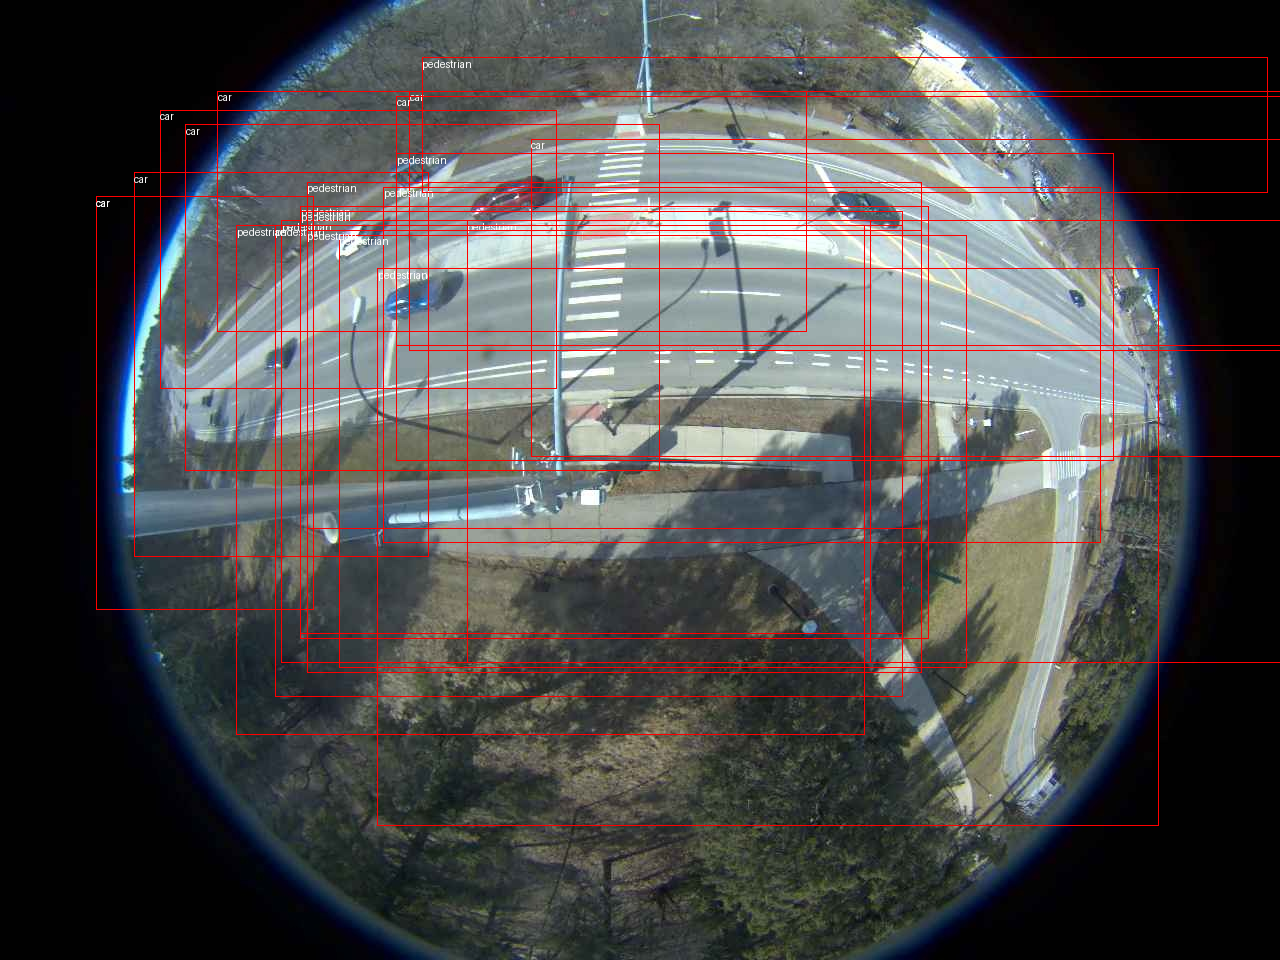

In [653]:
import torch
import requests

device = "cuda"

from PIL import Image, ImageDraw
from transformers import AutoImageProcessor, AutoModelForObjectDetection

image = Image.open("./beal_clip10_2023-02-20_13-09-07-353621.jpg")
draw = ImageDraw.Draw(image)
image_width = image.size[0]
image_height = image.size[1]

with torch.no_grad():
    inputs = image_processor(images=[image], return_tensors="pt")
    outputs = model(**inputs.to(device))
    # target_sizes = torch.tensor([[image.size[1], image.size[0]]])
    results = post_process_object_detection(outputs, threshold=0.3)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    center_x, center_y, width, height = tuple(box)
    print(center_x, center_y, width, height)
    top_left_x, top_left_y, width, height = yolo_to_coco(
        center_x, center_y, width, height, image_width, image_height
    )
    draw.rectangle(
        (top_left_x, top_left_y, top_left_x + width, top_left_y + height),
        outline="red",
        width=1,
    )
    draw.text(
        (top_left_x, top_left_y), model.config.id2label[label.item()], fill="white"
    )

image